In [1]:
%matplotlib inline

import cv2
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from loader import load_dataset, convert_to_one_hot, random_mini_batches, predict

In [2]:
# Data Paths

#full = 'data/dogsvcats.hdf5'
#X_train_orig, Y_train_orig, X_val_orig, Y_val_orig, X_test_orig, Y_test_orig = load_dataset(full)

sample = 'data/dogsvcats-sample.hdf5'
X_train_orig, Y_train_orig, X_val_orig, Y_val_orig, X_test_orig, Y_test_orig = load_dataset(sample)

y = 0


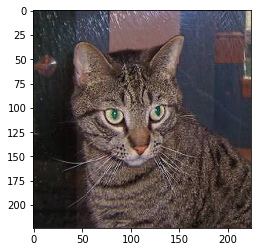

In [3]:
index = 3
plt.imshow(X_train_orig[index])
print("y = "+str(np.squeeze(Y_train_orig[:, index])))

y = 1


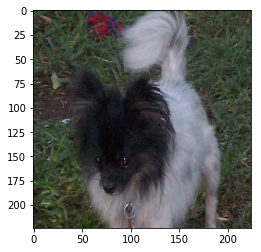

In [4]:
plt.imshow(X_val_orig[index])
print("y = "+str(np.squeeze(Y_val_orig[:,index])))

In [5]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_val_flatten = X_val_orig.reshape(X_val_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

X_train = X_train_flatten/255.
X_val = X_val_flatten/255.
X_test = X_test_flatten/255.

Y_train = convert_to_one_hot(Y_train_orig, 2)
Y_val = convert_to_one_hot(Y_val_orig, 2)
Y_test = convert_to_one_hot(Y_test_orig, 2)

print ("number of training examples = " + str(X_train.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("\nnumber of validation examples = " + str(X_val.shape[1]))
print ("X_val shape "+str(X_val.shape))
print ("Y_val shape"+str(Y_val.shape))
print ("\nnumber of test examples = " + str(X_test.shape[1]))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 60
X_train shape: (150528, 60)
Y_train shape: (2, 60)

number of validation examples = 20
X_val shape (150528, 20)
Y_val shape(2, 20)

number of test examples = 20
X_test shape: (150528, 20)
Y_test shape: (2, 20)


In [6]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 224 * 224 * 3 = 150528)
    n_y -- scalar, number of classes (from 0 to 1, so -> 2)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    ### END CODE HERE ###
    
    return X, Y

In [7]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [50, 150528]
                        b1 : [50, 1]
                        W2 : [25, 50]
                        b2 : [25, 1]
                        W3 : [2, 25]
                        b3 : [2, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    
    """
    W1 = tf.get_variable("W1", [50, 150528], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [50, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [25, 50], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [25, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [2, 1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [8]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)                     
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    return Z3

In [9]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (2, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    ### END CODE HERE ###
    
    return cost

In [10]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    seed = 3
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Val Accuracy:", accuracy.eval({X: X_val, Y: Y_val}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Cost after epoch 0: 1.680811
Cost after epoch 100: 0.035185
Cost after epoch 200: 0.011546
Cost after epoch 300: 0.005969
Cost after epoch 400: 0.003550
Cost after epoch 500: 0.001588
Cost after epoch 600: 0.000815
Cost after epoch 700: 0.000498
Cost after epoch 800: 0.000333
Cost after epoch 900: 0.000239
Cost after epoch 1000: 0.000178
Cost after epoch 1100: 0.000136
Cost after epoch 1200: 0.000106
Cost after epoch 1300: 0.000083
Cost after epoch 1400: 0.000068


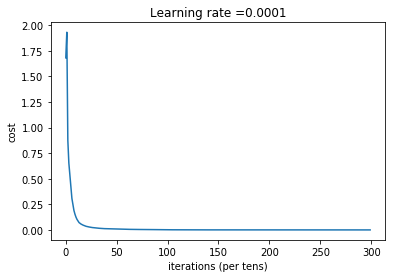

Parameters have been trained!
Train Accuracy: 1.0
Val Accuracy: 0.7
Test Accuracy: 0.5


In [11]:
parameters = model(X_train, Y_train, X_test, Y_test)

Your algorithm predicts: y = 0


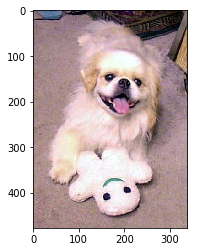

In [13]:
import scipy
from PIL import Image
from scipy import ndimage

my_image = "sample.jpg"

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(224, 224)).reshape((1, 224 * 224 * 3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))